
# 🌳 DETECCIÓN DE ÁRBOLES CON DEEPFOREST



## Importe de dependencias


In [2]:
import os
import rasterio
from rasterio.windows import Window
from rasterio.warp import transform_bounds
from shapely.geometry import box
import geopandas as gpd
import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image
import warnings
import sklearn
import torch
warnings.filterwarnings('ignore')

## Definición de  rutas principales

In [21]:
raster_path = "E:/Segmentación_mosaico/Raster_maduro2.tif"
vector_path = "E:/Segmentación_mosaico/Vector/Vector1.shp"
output_dir = "E:/Segmentación_mosaico/DeepForest"
os.makedirs(output_dir, exist_ok=True)

In [26]:
# --- 3. DIVIDIR RASTER EN TILES (400x400 píxeles con overlap) ---
tile_size = 900
overlap = 250  # Píxeles de solapamiento entre tiles
tiles_dir = os.path.join(output_dir, "images")
os.makedirs(tiles_dir, exist_ok=True)

print("📦 Generando tiles con overlap...")
tile_metadata = []

with rasterio.open(raster_path) as src:
    print(f"📐 Dimensiones del raster: {src.width}x{src.height}")
    print(f"📍 CRS: {src.crs}")

    # Calcular stride (paso entre tiles)
    stride = tile_size - overlap

    for i in tqdm(range(0, src.height, stride)):
        for j in tqdm(range(0, src.width, stride)): # Added tqdm for inner loop
            # Ajustar el tamaño si estamos cerca del borde
            actual_height = min(tile_size, src.height - i)
            actual_width = min(tile_size, src.width - j)

            window = Window(j, i, actual_width, actual_height)
            transform = src.window_transform(window)

            # Nombre único del tile
            tile_name = f"tile_{i}_{j}.png"
            outpath = os.path.join(tiles_dir, tile_name)

            # Read data
            data = src.read(window=window)

            # Convert to RGB if necessary (DeepForest requires RGB)
            if data.shape[0] >= 3:
                rgb_data = data[:3, :, :]
            else:
                # If only 1 band, replicate it
                rgb_data = np.stack([data[0, :, :]] * 3, axis=0)

            # Normalize to 0-255
            rgb_data = np.clip(rgb_data, 0, 255).astype(np.uint8)

            # Save as PNG (more efficient for DeepForest)
            img = Image.fromarray(np.transpose(rgb_data, (1, 2, 0)))
            img.save(outpath)

            # Save metadata for coordinate mapping
            bounds = src.window_bounds(window)
            tile_metadata.append({
                'tile_name': tile_name,
                'col_off': j,
                'row_off': i,
                'width': actual_width,
                'height': actual_height,
                'bounds': bounds
            })

print(f"✅ {len(tile_metadata)} tiles generated in: {tiles_dir}")

# --- 4. LEER POLÍGONOS Y AJUSTAR CRS ---
trees = gpd.read_file(vector_path)
print(f"🌲 Polígonos cargados: {len(trees)}")
print(f"   CRS original: {trees.crs}")

with rasterio.open(raster_path) as src:
    raster_crs = src.crs

if trees.crs != raster_crs:
    print(f"🔄 Reproyecting to {raster_crs}...")
    trees = trees.to_crs(raster_crs)

# Validate geometries
trees = trees[trees.is_valid]
print(f"✅ Valid polygons: {len(trees)}")

# --- 5. ASOCIAR POLÍGONOS A CADA TILE ---
annotations = []
trees_per_tile = {}

print("📍 Extracting bounding boxes per tile...")
with rasterio.open(raster_path) as src:
    for tile_info in tqdm(tile_metadata):
        tile_name = tile_info['tile_name']
        j = tile_info['col_off']
        i = tile_info['row_off']

        # Create bounding box of the tile in geographic coordinates
        bounds = tile_info['bounds']
        tile_bbox = box(*bounds)

        # Find trees that intersect this tile
        subset = trees[trees.intersects(tile_bbox)]

        if subset.empty:
            continue

        trees_per_tile[tile_name] = len(subset)

        for _, row in subset.iterrows():
            geom = row.geometry
            xmin_geo, ymin_geo, xmax_geo, ymax_geo = geom.bounds

            # Convert geographic coordinates to tile pixels
            # rasterio.transform.rowcol converts geo -> pixel
            py_min, px_min = src.index(xmin_geo, ymax_geo)
            py_max, px_max = src.index(xmax_geo, ymin_geo) # Corrected from ymin_tile

            # Convert to relative tile coordinates
            xmin_tile = px_min - j
            ymin_tile = py_min - i
            xmax_tile = px_max - j
            ymax_tile = py_max - i

            # Clip to tile boundaries
            xmin_tile = max(0, min(xmin_tile, tile_info['width']))
            ymin_tile = max(0, min(ymin_tile, tile_info['height']))
            xmax_tile = max(0, min(xmax_tile, tile_info['width']))
            ymax_tile = max(0, min(ymax_tile, tile_info['height']))

            # Check if the bounding box is valid
            if xmax_tile > xmin_tile and ymax_tile > ymin_tile:
                # Calculate minimum area (filter very small detections)
                area = (xmax_tile - xmin_tile) * (ymax_tile - ymin_tile)
                if area >= 25:  # At least 5x5 pixels
                    annotations.append({
                        "image_path": tile_name,
                        "xmin": int(xmin_tile),
                        "ymin": int(ymin_tile),
                        "xmax": int(xmax_tile),
                        "ymax": int(ymax_tile),
                        "label": "Tree"
                    })

print(f"📊 Statistics:")
print(f"   - Tiles with trees: {len(trees_per_tile)}")
print(f"   - Total annotations: {len(annotations)}")
if trees_per_tile:
    print(f"   - Average trees/tile: {np.mean(list(trees_per_tile.values())):.1f}")

# --- 6. SAVE ANNOTATIONS.CSV ---
ann_path = os.path.join(output_dir, "annotations.csv")
df = pd.DataFrame(annotations)

if df.empty:
    print("⚠️ ERROR: No annotations generated. Check:")
    print("   1. That the shapefile and raster overlap spatially")
    print("   2. That the CRSs are compatible")
    print("   3. That the polygons are valid")
else:
    df.to_csv(ann_path, index=False)
    print(f"✅ Annotation file saved to: {ann_path}")
    print("\n📋 First annotations:")
    print(df.head(10))

    # Split into train/val (80/20)
    from sklearn.model_selection import train_test_split
    unique_images = df['image_path'].unique()
    train_imgs, val_imgs = train_test_split(unique_images, test_size=0.2, random_state=42)

    train_df = df[df['image_path'].isin(train_imgs)]
    val_df = df[df['image_path'].isin(val_imgs)]

    train_path = os.path.join(output_dir, "train_annotations.csv")
    val_path = os.path.join(output_dir, "val_annotations.csv")

    train_df.to_csv(train_path, index=False)
    val_df.to_csv(val_path, index=False)

    print(f"\n📂 Datasets:")
    print(f"   - Train: {len(train_df)} annotations ({len(train_imgs)} images)")
    print(f"   - Val: {len(val_df)} annotations ({len(val_imgs)} images)")

📦 Generando tiles con overlap...
📐 Dimensiones del raster: 13105x10998
📍 CRS: EPSG:32618


100%|██████████| 17/17 [01:28<00:00,  5.20s/it]


✅ 357 tiles generated in: E:/Segmentación_mosaico/DeepForest\images
🌲 Polígonos cargados: 666
   CRS original: EPSG:32618
✅ Valid polygons: 666
📍 Extracting bounding boxes per tile...


100%|██████████| 357/357 [00:00<00:00, 479.40it/s]

📊 Statistics:
   - Tiles with trees: 145
   - Total annotations: 1116
   - Average trees/tile: 10.1
✅ Annotation file saved to: E:/Segmentación_mosaico/DeepForest\annotations.csv

📋 First annotations:
           image_path  xmin  ymin  xmax  ymax label
0     tile_0_8450.png   372     0   900   364  Tree
1     tile_0_9100.png     0     0   900   364  Tree
2     tile_0_9750.png     0     0   533   364  Tree
3  tile_1950_3900.png   871   558   900   900  Tree
4  tile_1950_3900.png   666   802   900   900  Tree
5  tile_1950_4550.png   221   558   593   900  Tree
6  tile_1950_4550.png   633   786   850   900  Tree
7  tile_1950_4550.png    16   802   351   900  Tree
8  tile_1950_5200.png     0   786   200   900  Tree
9  tile_2600_3900.png   871     0   900   262  Tree

📂 Datasets:
   - Train: 849 annotations (116 images)
   - Val: 267 annotations (29 images)


Quitar alfa

In [35]:
import rasterio
from rasterio.enums import Resampling

with rasterio.open(raster_path) as src:
    img = src.read([1, 2, 3], out_dtype='uint8', resampling=Resampling.nearest)  # toma solo las 3 primeras bandas
    profile = src.profile
    profile.update(count=3, dtype='uint8')

rgb_path = os.path.join(output_dir, "raster_RGB.tif")
with rasterio.open(rgb_path, 'w', **profile) as dst:
    dst.write(img)

raster_path = rgb_path
print(f"✅ Raster convertido a RGB en: {rgb_path}")

✅ Raster convertido a RGB en: E:/Segmentación_mosaico/DeepForest\raster_RGB.tif


In [ ]:
'''# --- 7. TRAIN DEEPFOREST MODEL ---
from deepforest import main
from deepforest import get_data
import torch

# Configure device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n🖥️ Using: {device}")

# Create model
model = main.deepforest()
model.config["train"]["csv_file"] = train_path
model.config["train"]["root_dir"] = tiles_dir
model.config["train"]["fast_dev_run"] = False
model.config["batch_size"] = 4
model.config["score_thresh"] = 0.2  # Confidence threshold
model.config["train"]["epochs"] = 10  # 🔥 Ajusta aquí el número de épocas

# Load pretrained weights (recommended)
model.load_model()
print("✅ Pretrained weights loaded")

print("\n🚀 Starting training...")
print("=" * 50)

model_path = os.path.join(output_dir, "deepforest_citricos.pl")

try:
    model.trainer.fit(model)
    from pytorch_lightning.callbacks import ModelCheckpoint

    checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",     # monitorea la pérdida de validación
    mode="min",             # busca el valor mínimo
    save_top_k=1,           # guarda solo el mejor
    filename="best_model-{epoch:02d}-{val_loss:.2f}"
    )

    model.trainer.callbacks.append(checkpoint_callback)

    model_path = os.path.join(output_dir, "deepforest_citricos.pl")
    model.save(model_path)
    print(f"\n✅ Model saved to: {model_path}")
except Exception as e:
    print(f"⚠️ Error during training: {e}")
    print("Try reducing batch_size or checking annotations")
'''
# --- 7. TRAIN DEEPFOREST MODEL ---
#import os
#import torch
#from deepforest import main
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

# --- CONFIGURAR DISPOSITIVO ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n🖥️ Using: {device}")

# --- CREAR Y CONFIGURAR MODELO ---
model = main.deepforest()
model.config["train"]["csv_file"] = train_path
model.config["train"]["root_dir"] = tiles_dir
model.config["train"]["fast_dev_run"] = False
model.config["batch_size"] = 3
model.config["score_thresh"] = 0.2
model.config["train"]["epochs"] = 5  # 🔥 Número de épocas ajustable
model.config["validation"]["size"] = 900


# --- CARGAR PESOS PREENTRENADOS ---
model.load_model()
print("✅ Pretrained weights loaded")

# --- CONFIGURAR CALLBACKS ---
checkpoint_callback = ModelCheckpoint(
    monitor="train_loss_epoch",          # Monitorear pérdida de validación
    mode="min",                  # Guardar cuando sea mínima
    save_top_k=1,                # Solo el mejor modelo
    dirpath=output_dir,          # Carpeta de salida
    filename="best_model-{epoch:02d}-{val_loss:.2f}"
)

early_stop_callback = EarlyStopping(
    monitor="train_loss_epoch",
    patience=5,                  # Detiene si no mejora en 5 épocas
    mode="min"
)

# Agregar callbacks al trainer antes del entrenamiento
model.trainer.callbacks.extend([checkpoint_callback, early_stop_callback])

# --- ENTRENAR MODELO ---
print("\n🚀 Starting training...")
print("=" * 50)

try:
    model.trainer.fit(model)

    # Guardar el modelo final (último estado del entrenamiento)
    model_path = os.path.join(output_dir, "deepforest_citricos_final.pl")
    model.trainer.save_checkpoint(model_path)
    print(f"\n✅ Último modelo guardado en: {model_path}")

    # Mostrar la ruta del mejor modelo guardado automáticamente
    best_model_path = checkpoint_callback.best_model_path
    print(f"🏆 Mejor modelo guardado automáticamente en: {best_model_path}")

except Exception as e:
    print(f"⚠️ Error durante entrenamiento: {e}")
    print("👉 Intenta reducir el batch_size o revisar las anotaciones")

# --- 8. EVALUATE MODEL ---
if not val_df.empty and os.path.exists(model_path):
    print("\n📊 Evaluating on validation set...")

    # Predicción por tiles
    predictions = model.predict_tile(
    path=raster_path,
    patch_size=800,
    patch_overlap=0.2
    )

    #print("\n📈 Evaluation metrics:")
    #print(results)

    # Save metrics
    results_path = os.path.join(output_dir, "evaluation_results.csv")
    results.to_csv(results_path)
    print(f"💾 Results saved to: {results_path}")

# --- 9. VISUALIZE SAMPLE PREDICTIONS ---
import os
import matplotlib.pyplot as plt
from PIL import Image

sample_tiles = val_imgs[:3] if len(val_imgs) >= 3 else list(unique_images)[:3]
if len(sample_tiles) == 0:
    sample_tiles = [val_imgs[0]]

fig, axes = plt.subplots(1, len(sample_tiles), figsize=(15, 5))
if len(sample_tiles) == 1:
    axes = [axes]

print("\n🖼️ Generating sample predictions...")
for idx, tile_name in enumerate(sample_tiles):
    tile_path = os.path.join(tiles_dir, tile_name)
    print(f"Predicting {tile_path}...")

    # Predict
    pred_df = model.predict_image(path=tile_path)

    # Load image
    img = Image.open(tile_path)
    axes[idx].imshow(img)

    # Draw predictions
    if pred_df is not None and not pred_df.empty:
        for _, row in pred_df.iterrows():
            rect = plt.Rectangle(
                (row['xmin'], row['ymin']),
                row['xmax'] - row['xmin'],
                row['ymax'] - row['ymin'],
                fill=False,
                edgecolor='red',
                linewidth=2
            )
            axes[idx].add_patch(rect)
            axes[idx].text(
                row['xmin'], row['ymin'] - 5,
                f"{row['score']:.2f}",
                color='red',
                fontsize=8,
                weight='bold'
            )

    axes[idx].set_title(f"{tile_name}\n{len(pred_df) if pred_df is not None else 0} detections")
    axes[idx].axis('off')

plt.tight_layout()
preds_path = os.path.join(output_dir, "sample_predictions.png")
plt.savefig(preds_path, dpi=150, bbox_inches='tight')
print(f"✅ Visualization saved to: {preds_path}")
plt.show()


GPU available: False, used: False
TPU available: False, using: 0 TPU cores



🖥️ Using: cpu



  | Name                 | Type                  | Params | Mode 
-----------------------------------------------------------------------
0 | iou_metric           | IntersectionOverUnion | 0      | train
1 | mAP_metric           | MeanAveragePrecision  | 0      | train
2 | empty_frame_accuracy | BinaryAccuracy        | 0      | train
3 | model                | RetinaNetHub          | 32.1 M | train
-----------------------------------------------------------------------
31.9 M    Trainable params
222 K     Non-trainable params
32.1 M    Total params
128.592   Total estimated model params size (MB)
205       Modules in train mode
0         Modules in eval mode


✅ Pretrained weights loaded

🚀 Starting training...
Epoch 0: 100%|██████████| 39/39 [06:05<00:00,  0.11it/s, v_num=16]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 39/39 [06:08<00:00,  0.11it/s, v_num=16]

✅ Último modelo guardado en: E:/Segmentación_mosaico/DeepForest\deepforest_citricos_final.pl
🏆 Mejor modelo guardado automáticamente en: E:\Segmentación_mosaico\DeepForest\best_model-epoch=00-val_loss=0.00-v6.ckpt

📊 Evaluating on validation set...
Predicting DataLoader 0: 100%|██████████| 119/119 [07:19<00:00,  0.27it/s]
1153 predictions in overlapping windows, applying non-max suppression
684 predictions kept after non-max suppression

📈 Evaluation metrics:


NameError: name 'results' is not defined


📊 Evaluating on validation set...
Predicting DataLoader 0: 100%|██████████| 119/119 [10:53<00:00,  0.18it/s]
1153 predictions in overlapping windows, applying non-max suppression
684 predictions kept after non-max suppression

💾 Guardando predicciones por tiles...
✅ Predicciones guardadas en: E:/Segmentación_mosaico/DeepForest\predicciones_tiles.csv

🖼️ Generating sample predictions...
Predicting E:/Segmentación_mosaico/DeepForest\images\tile_6500_5200.png...
Predicting E:/Segmentación_mosaico/DeepForest\images\tile_10400_3900.png...
Predicting E:/Segmentación_mosaico/DeepForest\images\tile_4550_3250.png...
✅ Visualization saved to: E:/Segmentación_mosaico/DeepForest\sample_predictions.png


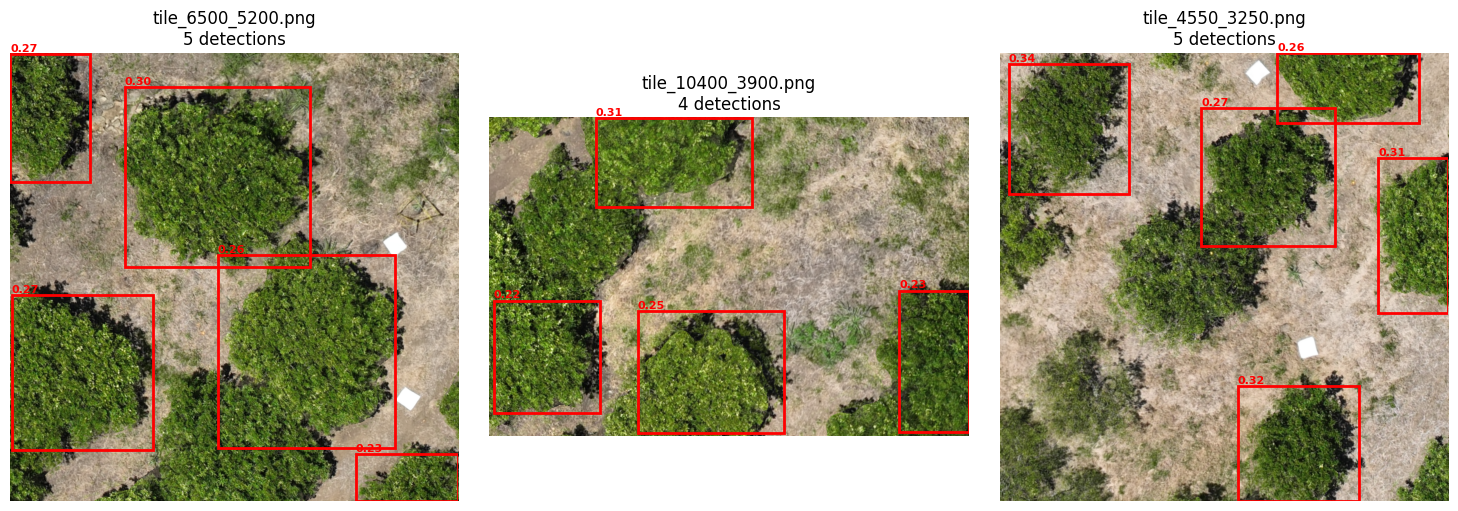

In [38]:

# --- 8. EVALUATE MODEL ---
if not val_df.empty and os.path.exists(model_path):
    print("\n📊 Evaluating on validation set...")

    # Predicción por tiles
    predictions = model.predict_tile(
    path=raster_path,
    patch_size=800,
    patch_overlap=0.2
    )

    # --- 8. SAVE PREDICTIONS FROM TILE INFERENCE ---
print("\n💾 Guardando predicciones por tiles...")

preds_path = os.path.join(output_dir, "predicciones_tiles.csv")
predictions.to_csv(preds_path, index=False)

print(f"✅ Predicciones guardadas en: {preds_path}")

# --- 9. VISUALIZE SAMPLE PREDICTIONS ---
import os
import matplotlib.pyplot as plt
from PIL import Image

sample_tiles = val_imgs[:3] if len(val_imgs) >= 3 else list(unique_images)[:3]
if len(sample_tiles) == 0:
    sample_tiles = [val_imgs[0]]

fig, axes = plt.subplots(1, len(sample_tiles), figsize=(15, 5))
if len(sample_tiles) == 1:
    axes = [axes]

print("\n🖼️ Generating sample predictions...")
for idx, tile_name in enumerate(sample_tiles):
    tile_path = os.path.join(tiles_dir, tile_name)
    print(f"Predicting {tile_path}...")

    # Predict
    pred_df = model.predict_image(path=tile_path)

    # Load image
    img = Image.open(tile_path)
    axes[idx].imshow(img)

    # Draw predictions
    if pred_df is not None and not pred_df.empty:
        for _, row in pred_df.iterrows():
            rect = plt.Rectangle(
                (row['xmin'], row['ymin']),
                row['xmax'] - row['xmin'],
                row['ymax'] - row['ymin'],
                fill=False,
                edgecolor='red',
                linewidth=2
            )
            axes[idx].add_patch(rect)
            axes[idx].text(
                row['xmin'], row['ymin'] - 5,
                f"{row['score']:.2f}",
                color='red',
                fontsize=8,
                weight='bold'
            )

    axes[idx].set_title(f"{tile_name}\n{len(pred_df) if pred_df is not None else 0} detections")
    axes[idx].axis('off')

plt.tight_layout()
preds_path = os.path.join(output_dir, "sample_predictions.png")
plt.savefig(preds_path, dpi=150, bbox_inches='tight')
print(f"✅ Visualization saved to: {preds_path}")
plt.show()


In [ ]:
results = model.evaluate(csv_file=val_path, root_dir=tiles_dir, iou_threshold=0.5)
print(results)


In [1]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# --- EVALUAR DETALLES DE PRECISIÓN ---
if not val_df.empty and os.path.exists(model_path):
    print("\n📊 Evaluando predicciones detalladas...")

    # Obtener predicciones sobre el conjunto de validación
    predictions = model.predict_file(csv_file=val_path, root_dir=tiles_dir)

    # Las predicciones incluyen columnas: image_path, xmin, ymin, xmax, ymax, score, label
    # Puedes combinarlas con tus anotaciones reales (val_df)

    # Convertir ambos DataFrames a listas de clases detectadas (por imagen)
    y_true = []
    y_pred = []

    for image_name in val_df["image_path"].unique():
        gt_labels = val_df[val_df["image_path"] == image_name]["label"].tolist()
        pred_labels = predictions[predictions["image_path"] == image_name]["label"].tolist()
        
        # En detección, emparejar etiquetas puede ser complejo,
        # pero si cada imagen tiene un solo objeto o una clase dominante, puedes usar:
        if len(pred_labels) > 0:
            y_pred.append(pred_labels[0])
            y_true.append(gt_labels[0])
    
    # Calcular métricas
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred)

    print(f"\n✅ Accuracy: {acc:.4f}")
    print("\n📋 Classification Report:")
    print(report)
    print("\n🧩 Matriz de Confusión:")
    print(cm)


NameError: name 'val_df' is not defined

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de confusión - DeepForest")
plt.xlabel("Predicciones")
plt.ylabel("Etiquetas verdaderas")
plt.show()
